### ECG Signals - SPEK

In this notebook we explore spectrograms as input representation for our deep learning model.

In [2]:
import torch
import torchaudio 
import wfdb
import sys
import wfdb
import numpy as np
import matplotlib.pyplot as plt

print('Virtual Environment:')
print(sys.prefix)

Virtual Environment:
c:\Users\Pie\Desktop\Thesis\code\signal-denoising\.venv


#### Updated Spectrogram Methods

Square tensors (spectrograms) are obtained by taking the right values for samples_to, n_fft and hop_length.

A bigger problem is the reconstruction part. We lose phase information, which means we will have to work with a lossy reconstruction. PytorchAudio has a Griffin Lim implementation we use for now. The probably best approach would be to use gradient ascent. Additional recources.

- https://pytorch.org/audio/stable/transforms.html
- https://reference.wolfram.com/language/ref/InverseSpectrogram.html
- https://de.mathworks.com/help/signal/ug/signal-recovery-with-differentiable-scalograms-and-spectrograms.html#SignalRecoveryWithDifferentiableSPExample-1 



**Method 1:**
- Using lossy conversion with Griffin [PytorchAudio]

In [3]:
def plot_multiple_timeseries(signals, names):
    num_signals = len(signals)
    
    plt.figure(figsize=(5 * num_signals, 4))

    for i, (signal, name) in enumerate(zip(signals, names), 1):
        plt.subplot(1, num_signals, i)
        plt.plot(signal)
        plt.title(name)
        plt.xlabel('Sample')
        plt.ylabel('Amplitude')

    plt.tight_layout()
    plt.show()

def visualize_tensor(tensor):
    """
    Visualize a tensor as an image.
    
    Parameters:
    tensor (torch.Tensor): The input tensor with shape [3, 540, 540].
    """
    # Convert the tensor to a NumPy array
    image_array = tensor.numpy()

    # Transpose the array to (H, W, C) format
    image_array = image_array.transpose(1, 2, 0)

    # Display the image using Matplotlib
    plt.imshow(image_array)
    plt.axis('off')  # Turn off axis
    plt.show()

In [99]:
def ecg_to_spectrogram_log(ecg_signal, n_fft=32, hop_length=4):
    # Reshape ECG signal to (batch_size, num_channels, signal_length)
    ecg_signal = ecg_signal.unsqueeze(0).unsqueeze(0)

    # Compute spectrogram
    spectrogram = torchaudio.transforms.Spectrogram(n_fft=n_fft, hop_length=hop_length)(ecg_signal)
    spec = spectrogram[0]   ## this is already the abs of STFT 'positive'

    # Check the range of values in the spectrogram
    print('Min value:', torch.min(spec))
    print('Max value:', torch.max(spec))

    # Take log 
    spec_log = torch.log10(spec)

    # Check the range of values after taking the absolute value
    print('Min value after taking log:', torch.min(spec_log))
    print('Max value after taking log:', torch.max(spec_log))

    return spec_log

def spectrogram_log_to_ecg(spec_log, n_fft=32, hop_length=None,n_iter=400):
    """
    Convert spectrogram back to ECG signal using torchaudio library.

    Args:
    - spectrogram (torch.Tensor): Spectrogram of the ECG signal.
    - n_fft (int): Size of FFT window. Default is 400.
    - hop_length (int or None): Number of samples between successive frames.
      If None, defaults to n_fft / 4. Default is None.

    Returns:
    - torch.Tensor: Reconstructed ECG signal.
    """
  
    # Undo log operation
    spec = torch.pow(10, spec_log)

    # Debugging purpose
    print('Griffin Time...', spec.shape)

    # Compute inverse spectrogram
    ecg_signal = torchaudio.transforms.GriffinLim(n_fft=n_fft,  n_iter=400, hop_length=hop_length)(spec)

    # Squeeze the batch and channel dimensions
    ecg_signal = ecg_signal.squeeze(0).squeeze(0)

    return ecg_signal

In [55]:
# samples_to = (62*16) + 16
# n_fft = 126
# hop_length = 16

# # Load Data
# path_102 = "data/ardb/104"
# record_102 = wfdb.rdsamp(path_102, sampto=samples_to)
# signal_102 = record_102[0][:, 0]
# signal_102 = signal_102

# # Build and Visualize Spectrogram
# sig = torch.tensor(signal_102)
# spek_log = ecg_to_spectrogram_log(sig,n_fft=n_fft, hop_length=hop_length)
# visualize_tensor(spek_log)

# # Visualize reoncstruction using Griffin...
# reconstructed_sig = spectrogram_log_to_ecg(spek_log,n_fft,hop_length)
# reconstructed_sig = -reconstructed_sig                                        # flip phase for whatever reason...
# plot_multiple_timeseries([sig, reconstructed_sig], ['Original', 'Griffin Reconstruction', 'Griffin New'])

# # Info
# print('Number of samples:', samples_to)
# print('Duration in seconds:', samples_to/360)
# print('Shape of spectrogram:',spek_log.shape)


Duration in seconds... 5.644444444444445
Samples 2032
n_fft 254
Min value: tensor(4.3776e-07, dtype=torch.float64)
Max value: tensor(1290.7413, dtype=torch.float64)
Min value after taking log: tensor(-6.3588, dtype=torch.float64)
Max value after taking log: tensor(3.1108, dtype=torch.float64)


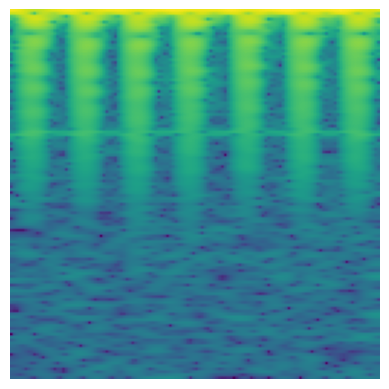

Griffin Time... torch.Size([1, 128, 128])


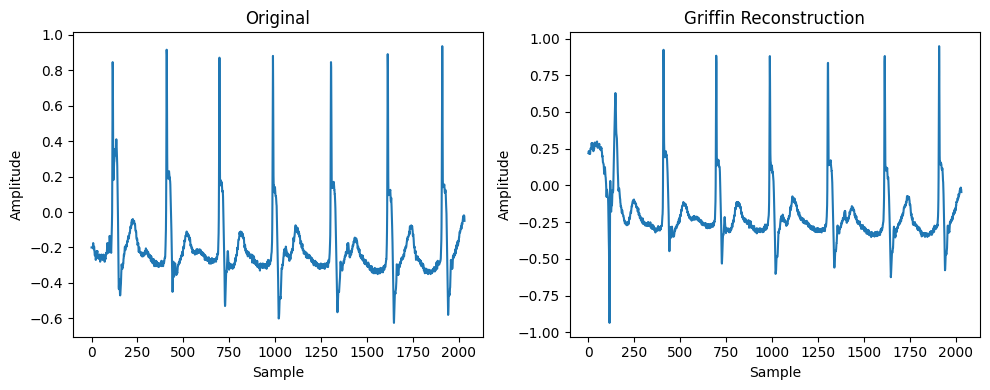

Number of samples: 2032
Duration in seconds: 5.644444444444445


In [100]:
######### Parameters ##########
samples_to = ((62*8*4) + 16) + 32
n_fft = 63*4 + 2
hop_length = 16

print('Duration in seconds...', samples_to/360)
print('Samples', samples_to)
print('n_fft', n_fft)

# Load Data
path_102 = "data/ardb/102"
record_102 = wfdb.rdsamp(path_102, sampto=samples_to)
signal_102 = record_102[0][:, 0]

# Build and Visualize Spectrogram
sig = torch.tensor(signal_102)
spek_log = ecg_to_spectrogram_log(sig,n_fft=n_fft, hop_length=hop_length)
visualize_tensor(spek_log)

# Visualize reoncstruction using Griffin...
reconstructed_sig = spectrogram_log_to_ecg(spek_log,n_fft,hop_length)
reconstructed_sig = - reconstructed_sig                                        # flip phase for whatever reason...
plot_multiple_timeseries([sig, reconstructed_sig], ['Original', 'Griffin Reconstruction', 'Griffin New'])

# Info
print('Number of samples:', samples_to)
print('Duration in seconds:', samples_to/360)

#### Advanced Reconstruction

<span style="color:lightgreen">! REQUIRES MATLAB (TOOLBOXES) AND PTYHON 3.9, 3.10 or 3.11</span>.

Tutorial on syntax when using matlab engine to call  (toolbox) matlab methods: https://stackoverflow.com/questions/67215683/specifying-arguments-of-matlab-functions-in-python

**Method 2:**
-  stftmag2sig from Matlab

In [15]:
# %pip install matlabengine

import matlab.engine
eng = matlab.engine.start_matlab()

eng.addpath( "C:\Program Files\MATLAB\R2024a\toolbox\signal")
eng.addpath( "C:\Program Files\MATLAB\R2024a\toolbox\dsp" )

'C:\\Users\\Pie\\Documents\\MATLAB;C:\\Users\\Pie\\Documents\\MATLAB\\wfdbtoolbox\\mcode;C:\\Program Files\\MATLAB\\R2024a\\toolbox\\matlab\\addon_enable_disable_management\\matlab;C:\\Program Files\\MATLAB\\R2024a\\toolbox\\matlab\\addon_updates\\matlab;C:\\Program Files\\MATLAB\\R2024a\\toolbox\\matlab\\addons;C:\\Program Files\\MATLAB\\R2024a\\toolbox\\matlab\\addons\\cef;C:\\Program Files\\MATLAB\\R2024a\\toolbox\\matlab\\addons\\fileexchange;C:\\Program Files\\MATLAB\\R2024a\\toolbox\\matlab\\addons\\supportpackages;C:\\Program Files\\MATLAB\\R2024a\\toolbox\\matlab\\addons_common\\matlab;C:\\Program Files\\MATLAB\\R2024a\\toolbox\\matlab\\addons_desktop_registration;C:\\Program Files\\MATLAB\\R2024a\\toolbox\\matlab\\addons_install_location\\matlab;C:\\Program Files\\MATLAB\\R2024a\\toolbox\\matlab\\addons_product;C:\\Program Files\\MATLAB\\R2024a\\toolbox\\matlab\\addons_product_support\\matlab;C:\\Program Files\\MATLAB\\R2024a\\toolbox\\matlab\\addons_registry\\matlab;C:\\Progr

In [101]:
# Undo log operation
spek_abs_tensor = torch.pow(10, spek_log)

# Tensor --> Numpy
spek_abs_np = spek_abs_tensor.detach().cpu().numpy()
spek_abs_np = np.squeeze(spek_abs_np)
print(spek_abs_np.shape)

# Python --> Matlab
matlab_spek_abs = matlab.double(spek_abs_np)

(128, 128)


In [107]:
# Clean up...
matlab_abs_s = matlab_spek_abs

# Size
s = float(len(signal_102))
print('s', s)

# Used to build hann window
hann = torch.hann_window(n_fft).detach().cpu().numpy()
print(hann.shape)
hann_window = eng.hann(n_fft)

# # Call the MATLAB function stftmag2sig
result = eng.stftmag2sig(matlab_abs_s, 128.0,"Method", "gd", "Optimizer", "lbfgs", "MaxIterations", 1000.0, "InconsistencyTolerance", 0.001, "Overlaplength",16.0)

print(result)

# # Convert MATLAB array to Python array
result = np.array(result._data).reshape(result.size[::-1]).T

print("Result as Python array:")
print(result)

plot_multiple_timeseries([result],['Reconstruction Matlab'])


s 2032.0
(254,)
